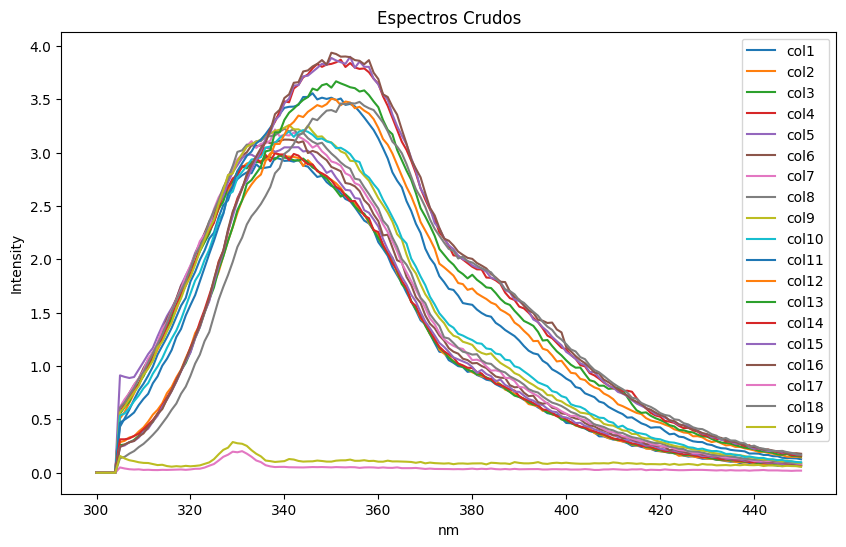

In [53]:
import pandas as pd
import matplotlib.pyplot as plt


# Read the CSV file with specified column names
df = pd.read_csv('espectros_crudos.csv', sep=';', decimal=',', names=['nm'] + [f'col{i}' for i in range(1, 20)])

# Convert the 'nm' column to a numeric type
df['nm'] = pd.to_numeric(df['nm'], errors='coerce')

#print(df.dtypes)
#print(df)

# Plot the data
plt.figure(figsize=(10,6))
for column in df.columns[1:]:
    plt.plot(df['nm'], pd.to_numeric(df[column]), label=column)

plt.xlabel('nm')
plt.ylabel('Intensity')
plt.title('Espectros Crudos')
plt.legend()
plt.show()

In [54]:
blanco = df.iloc[:, 17]

new_df = df.copy()
new_df.loc[:, 'col1':'col19'] = df.loc[:, 'col1':'col19'].apply(lambda x: blanco - x)
new_df.to_csv('sin_blanco.csv', index=False)


# Sumatoria de valores de columna de 310-420 nm sin blanco
sum_values = new_df.loc[:, 'col1':'col19'].iloc[11:122].sum()
#print(sum_values.iloc[0:3])

# Multiplicacion de valores de columna de 310-420 nm sin blanco por el nm
mult_values = new_df.loc[:, 'col1':'col19'].iloc[11:122].mul(new_df['nm'], axis=0)
#print(mult_values.iloc[0:3])

# Sumatoria de valores de columna de 310-420 nm sin blanco multiplicado por el nm
sum_mult_values = mult_values.loc[:, 'col1':'col19'].iloc[11:122].sum()
#print(sum_mult_values.iloc[0:3])

    ClGdn (M)      I355  I(310-420)          CM
0        0.00  2.437441  161.799629  349.822039
1        0.50  2.469790  165.343003  349.582818
2        1.50  2.443850  165.259994  349.558565
3        2.40  2.496030  166.448970  349.656500
4        3.20  2.523191  171.654081  349.654206
5        3.60  2.633360  175.965879  350.098205
6        3.80  2.662351  179.379594  350.390970
7        4.00  2.704770  182.122230  350.766790
8        4.15  2.868040  186.772795  351.670503
9        4.30  2.875370  184.975897  352.965896
10       4.60  3.382261  208.790889  355.250241
11       5.00  3.365171  204.645662  358.040077
12       5.25  3.552860  214.036884  358.720271
13       5.50  3.746951  226.222242  358.960652
14       5.80  3.743590  226.632380  359.084791
15       6.00  3.816221  229.996003  359.231457


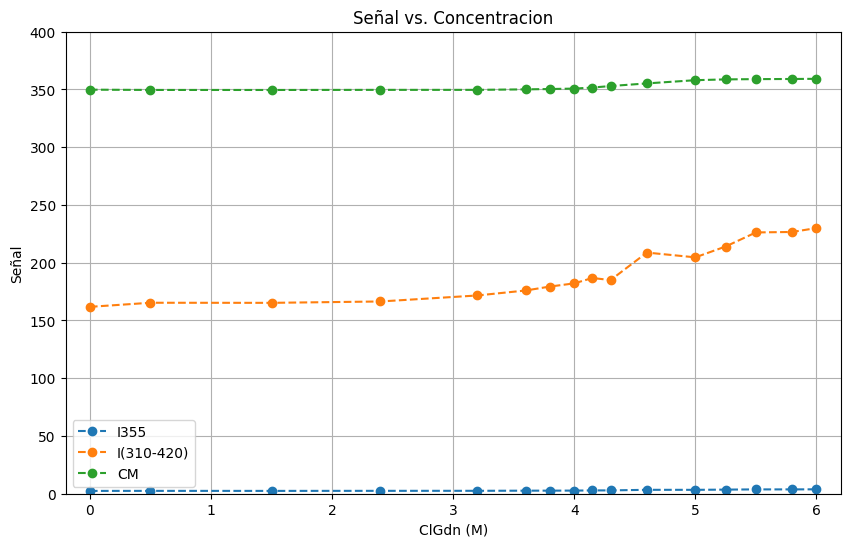

In [55]:
import numpy as np

concentrations = pd.DataFrame([0, 0.5, 1.5, 2.4, 3.2, 3.6, 3.8, 4, 4.15, 4.3, 4.6, 5, 5.25, 5.5, 5.8, 6], columns=['ClGdn (M)'])
#print(concentrations)
I355_values = pd.DataFrame(np.transpose(new_df.loc[new_df['nm'] == 355, 'col1':'col16'].values*-1), columns=['I355'])
#print(I355_values)
sum_values = pd.DataFrame(np.transpose(new_df.loc[:, 'col1':'col16'].iloc[11:122].sum().values*-1), columns=['I(310-420)'])
#print(sum_values)

sum_mult_values = pd.DataFrame(mult_values.loc[:, 'col1':'col16'].iloc[11:122].sum().values, columns=['I-Blanco x nm'])
CM = sum_mult_values.div(sum_values['I(310-420)']*-1, axis=0).rename(columns={'I-Blanco x nm': 'CM'})
#print(CM)

combined_df = pd.concat([concentrations, I355_values, sum_values, CM], axis=1)
print(combined_df)


plt.figure(figsize=(10, 6))

for column in ['I355', 'I(310-420)', 'CM']:
    plt.plot(combined_df['ClGdn (M)'], combined_df[column], marker='o', linestyle='--', label=column)

plt.xlabel('ClGdn (M)')
plt.ylabel('Señal')
plt.xlim(-0.2, 6.2)
plt.ylim(0, 400)
plt.title('Señal vs. Concentracion')
plt.grid(True)
plt.legend() 
plt.show()

In [56]:
combined_df = pd.concat([concentrations, I355_values, sum_values, CM], axis=1)
R_cte = 1.987
T_cte = 293

'''PRIMER GRAFICO'''
# Distinguir los puntos
Puntos_IU = 5
Puntos_IN = 5

x_IU_de_ITotal = combined_df['ClGdn (M)'].iloc[-Puntos_IU:]
y_IU_de_ITotal = combined_df['I(310-420)'].iloc[-Puntos_IU:]

x_IN_de_ITotal = combined_df['ClGdn (M)'].iloc[1:Puntos_IN]
y_IN_de_ITotal = combined_df['I(310-420)'].iloc[1:Puntos_IN]


# Regresion lineal de cada conjunto
z_IU = np.polyfit(x_IU_de_ITotal, y_IU_de_ITotal, 1)
p_IU = np.poly1d(z_IU)

z_IN = np.polyfit(x_IN_de_ITotal, y_IN_de_ITotal, 1)
p_IN = np.poly1d(z_IN)


'''SEGUNDO GRAFICO'''
# Fracciones calculadas de IU e IN a partir de I(310-420)
ITotal_df = pd.DataFrame({
    'IU (310-420)': p_IU(combined_df['ClGdn (M)']),
    'IN (310-420)': p_IN(combined_df['ClGdn (M)'])
})

ITotal_df['fu (310-420)'] = (combined_df['I(310-420)'] - ITotal_df['IN (310-420)']) / (ITotal_df['IU (310-420)'] - ITotal_df['IN (310-420)'])


'''TERCER GRAFICO'''
ITotal_df['Ku (310-420)'] = ITotal_df['fu (310-420)'] / (1 - ITotal_df['fu (310-420)'])
ITotal_df['Gu (310-420)'] = R_cte * T_cte * -np.log(ITotal_df['Ku (310-420)']) 
print(ITotal_df)


    IU (310-420)  IN (310-420)  fu (310-420)  Ku (310-420)  Gu (310-420)
0      83.905978    163.062690      0.015956      0.016215   2399.678634
1      96.283533    164.145275     -0.017650     -0.017343           NaN
2     121.038643    166.310444      0.023203      0.023754   2177.387896
3     143.318242    168.259097      0.072577      0.078256   1483.285892
4     163.122330    169.991233     -0.242084     -0.194901           NaN
5     173.024374    170.857300      2.357363     -1.736723           NaN
6     177.975396    171.290334      1.210050     -5.760768           NaN
7     182.926418    171.723368      0.928217     12.930885  -1490.186941
8     186.639685    172.048144      1.009122   -110.619721           NaN
9     190.352951    172.372919      0.700943      2.343844   -495.905928
10    197.779484    173.022470      1.444779     -3.248307           NaN
11    207.681528    173.888538      0.910163     10.131252  -1348.135985
12    213.870306    174.429830      1.004224   -237

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


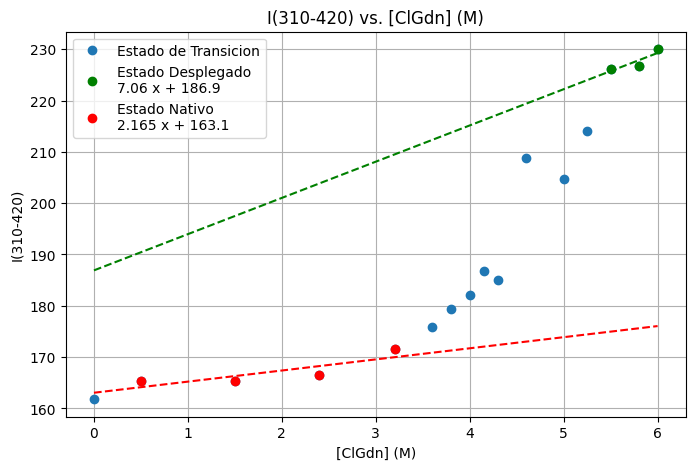

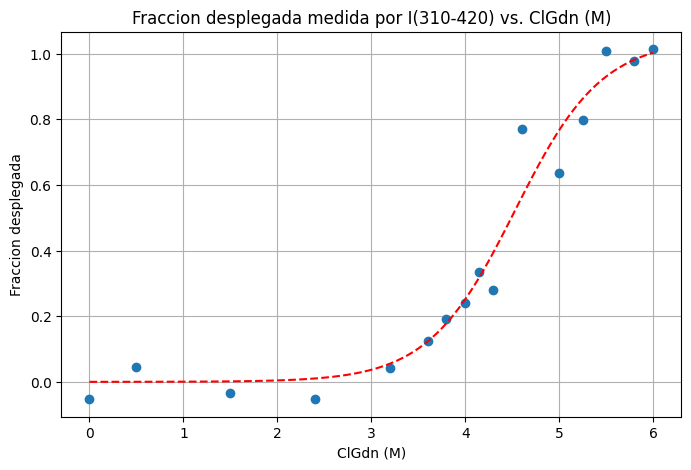

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


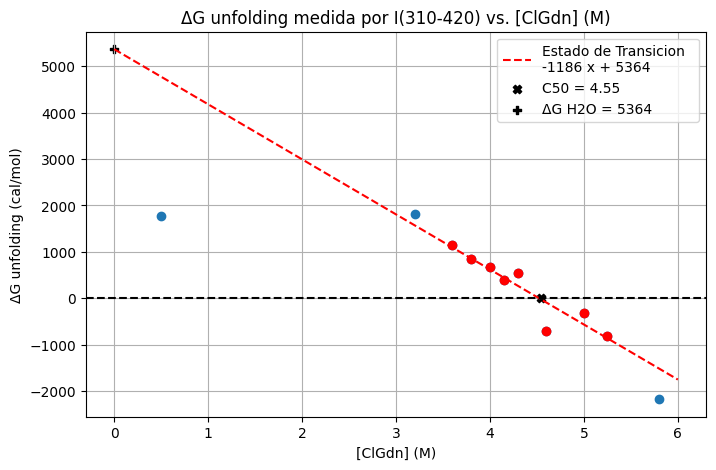

    IU_I(310-420)  IN_I(310-420)  fu_I(310-420)  Ku_I(310-420)  Gu_I(310-420)
0      186.906538     163.062690      -0.052972      -0.050307            NaN
1      190.436336     164.145275       0.045556       0.047731    1771.127144
2      197.495932     166.310444      -0.033684      -0.032586            NaN
3      203.849568     168.259097      -0.050860      -0.048398            NaN
4      209.497245     169.991233       0.042091       0.043941    1819.299273
5      212.321084     170.857300       0.123206       0.140518    1142.501018
6      213.733003     171.290334       0.190593       0.235472     841.943677
7      215.144922     171.723368       0.239486       0.314900     672.720883
8      216.203862     172.048144       0.333471       0.500310     403.183416
9      217.262801     172.372919       0.280753       0.390343     547.683699
10     219.380680     173.022470       0.771566       3.377632    -708.628313
11     222.204518     173.888538       0.636583       1.751659  

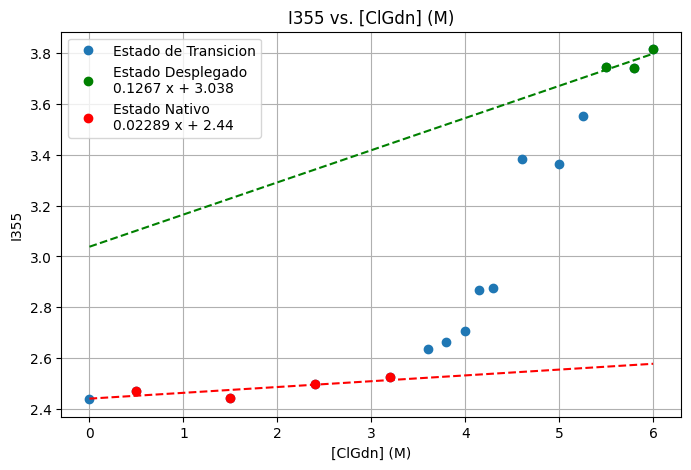

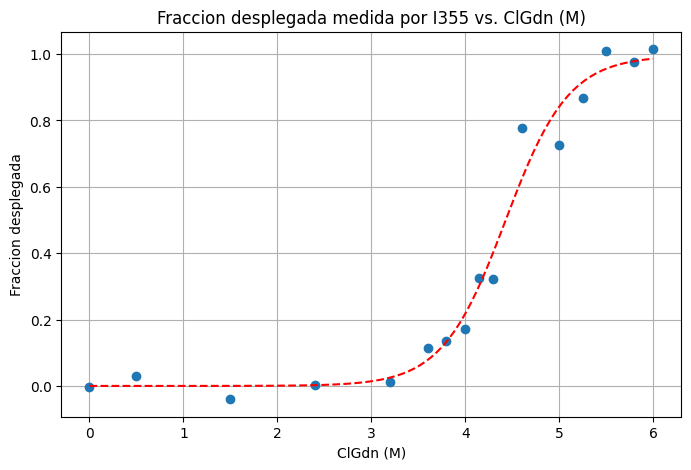

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


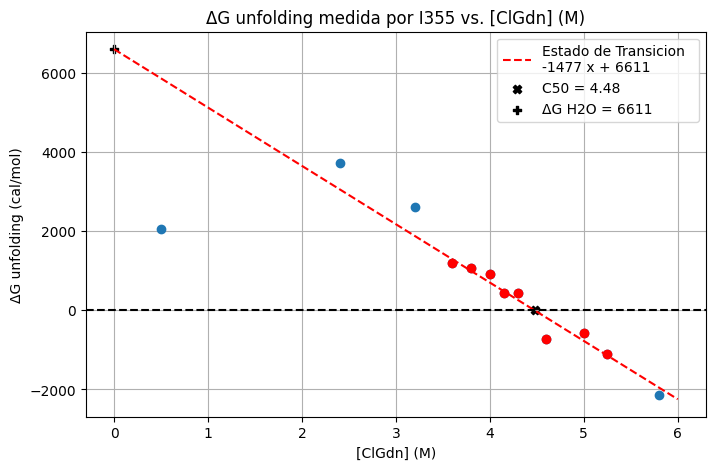

     IU_I355   IN_I355   fu_I355    Ku_I355      Gu_I355
0   3.038178  2.439733 -0.003830  -0.003816          NaN
1   3.101537  2.451176  0.028623   0.029466  2051.943944
2   3.228255  2.474061 -0.040057  -0.038514          NaN
3   3.342302  2.494658  0.001619   0.001621  3740.266498
4   3.443677  2.512967  0.010985   0.011107  2619.979356
5   3.494364  2.522121  0.114415   0.129197  1191.404319
6   3.519708  2.526698  0.136607   0.158221  1073.420879
7   3.545051  2.531276  0.171137   0.206473   918.457144
8   3.564059  2.534708  0.323828   0.478913   428.630495
9   3.583067  2.538141  0.322730   0.476517   431.550241
10  3.621082  2.545007  0.778062   3.505766  -730.305708
11  3.671770  2.554161  0.725665   2.645177  -566.319374
12  3.703449  2.559883  0.868317   6.593968 -1098.102650
13  3.735129  2.565604  1.010108 -99.931357          NaN
14  3.773144  2.572470  0.975386  39.626541 -2142.171276
15  3.798488  2.577047  1.014518 -69.882011          NaN


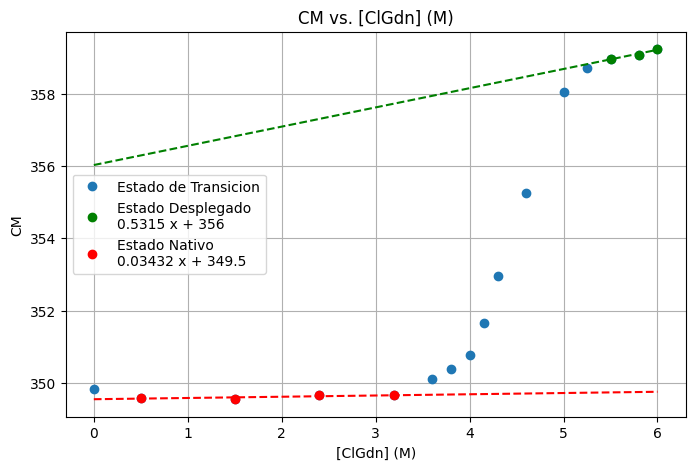

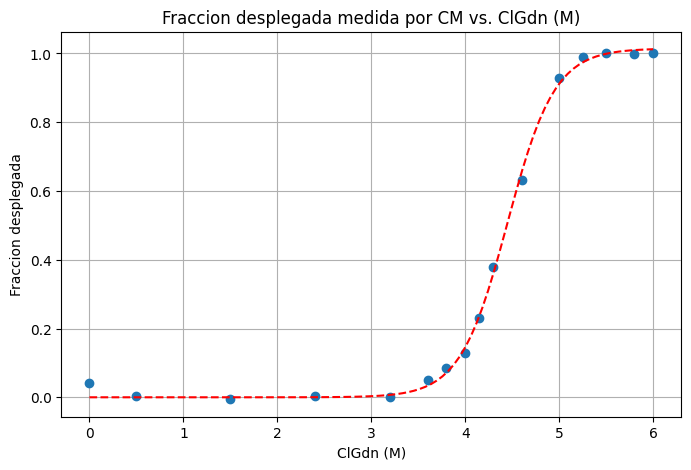

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


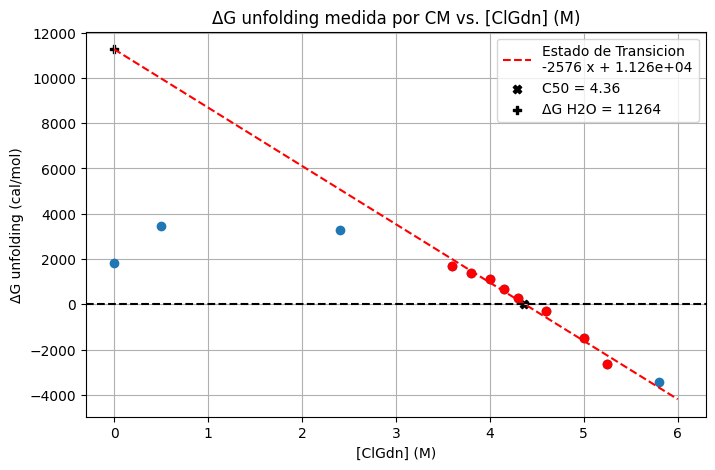

         IU_CM       IN_CM     fu_CM       Ku_CM        Gu_CM
0   356.027211  349.547810  0.042323    0.044194  1815.955568
1   356.292970  349.564971  0.002653    0.002660  3452.148698
2   356.824488  349.599293 -0.005637   -0.005605          NaN
3   357.302855  349.630183  0.003430    0.003442  3302.054689
4   357.728069  349.657641 -0.000426   -0.000425          NaN
5   357.940677  349.671370  0.051617    0.054426  1694.706211
6   358.046980  349.678234  0.085166    0.093095  1382.200308
7   358.153284  349.685099  0.127736    0.146442  1118.463089
8   358.233012  349.690247  0.231805    0.301753   697.550214
9   358.312740  349.695395  0.379525    0.611670   286.183650
10  358.472195  349.705692  0.632470    1.720865  -316.029056
11  358.684803  349.719421  0.928087   12.905730 -1489.053259
12  358.817682  349.728001  0.989283   92.312876 -2634.521185
13  358.950562  349.736582  1.001095 -914.134083          NaN
14  359.110017  349.746878  0.997306  370.166477 -3443.050119
15  359.

In [57]:
from sklearn.metrics import r2_score
import scipy.optimize as optimize

# Distinguir los puntos
Puntos_IU = 3
Puntos_IN = 5
figura=(8, 5)

for column in ['I(310-420)', 'I355', 'CM']:
    x_IU = combined_df['ClGdn (M)'].iloc[-Puntos_IU:]
    y_IU = combined_df[column].iloc[-Puntos_IU:]

    x_IN = combined_df['ClGdn (M)'].iloc[1:Puntos_IN]
    y_IN = combined_df[column].iloc[1:Puntos_IN]

    # Regresion lineal de cada conjunto
    z_IU = np.polyfit(x_IU, y_IU, 1)
    p_IU = np.poly1d(z_IU)    
    #R2_IU = r2_score(y_IU, p_IU(x_IU))

    z_IN = np.polyfit(x_IN, y_IN, 1)
    p_IN = np.poly1d(z_IN)
    #R2_IN = r2_score(y_IN, p_IN(x_IN))

    # print(f'Regresion IU: {p_IU}')
    # print("R2_IU:", R2_IU)
    # print(f'Regresion IN: {p_IN}')
    # print("R2_IN:", R2_IN)

    # Plot the original data
    plt.figure(figsize=figura)
    plt.plot(combined_df['ClGdn (M)'], combined_df[column], marker='o', linestyle='', label='Estado de Transicion')

    # Plot the regression points
    plt.plot(x_IU, y_IU, marker='o', color='green', label='Estado Desplegado {}'.format(p_IU), linestyle='')
    plt.plot(x_IN, y_IN, marker='o', color='red', label='Estado Nativo {}'.format(p_IN), linestyle='')

    # Plot the linear regression line
    xp_IU = np.linspace(0, 6, 100)
    plt.plot(xp_IU, p_IU(xp_IU), color='green', linestyle='--')

    xp_IN = np.linspace(0, 6, 100)
    plt.plot(xp_IN, p_IN(xp_IN), color='red', linestyle='--')

    plt.xlabel('[ClGdn] (M)')
    plt.ylabel(column)
    plt.title(column+' vs. [ClGdn] (M)')
    plt.legend()
    plt.grid(True)
    plt.show()

    '''SEGUNDO GRAFICO'''    
    # Fracciones calculadas de IU e IN
    ITotal_df = pd.DataFrame({
    'IU_'+column: p_IU(combined_df['ClGdn (M)']),
    'IN_'+column: p_IN(combined_df['ClGdn (M)'])
    })

    # Fracciones desplegadas
    ITotal_df['fu_'+column] = (combined_df[column] - ITotal_df['IN_'+column]) / (ITotal_df['IU_'+column] - ITotal_df['IN_'+column])
    #print(ITotal_df)
    
    plt.figure(figsize=figura)
    plt.plot(combined_df['ClGdn (M)'], ITotal_df['fu_'+column], marker='o', linestyle='')
    
    # Sigmoid adjustment
    popt, pcov = optimize.curve_fit(lambda x, a, b, c: a / (1 + np.exp(-b * x + c)), combined_df['ClGdn (M)'][1:], ITotal_df['fu_'+column][1:])

    # Plot adjusted curve
    xp = np.linspace(combined_df['ClGdn (M)'].min(), combined_df['ClGdn (M)'].max(), 100)
    plt.plot(xp, popt[0] / (1 + np.exp(-popt[1] * xp + popt[2])), linestyle='--', color='red')
        
    
    plt.xlabel('ClGdn (M)')
    plt.ylabel('Fraccion desplegada')
    plt.title('Fraccion desplegada medida por '+column+ ' vs. ClGdn (M)')
    plt.grid(True)
    plt.show()

    
    '''TERCER GRAFICO'''
    # Calculate Ku and Gu
    ITotal_df['Ku_'+column] = ITotal_df['fu_'+column] / (1 - ITotal_df['fu_'+column])
    ITotal_df['Gu_'+column] = -R_cte * T_cte * np.log(ITotal_df['Ku_'+column])

    # Plot data
    plt.figure(figsize=figura)
    plt.plot(combined_df['ClGdn (M)'], ITotal_df['Gu_'+column], marker='o', linestyle='')

    # Linear regression
    x_IT, y_IT = combined_df['ClGdn (M)'].iloc[Puntos_IN:len(combined_df['ClGdn (M)'])-Puntos_IU], ITotal_df['Gu_'+column].iloc[Puntos_IN:len(combined_df['ClGdn (M)'])-Puntos_IU]
    plt.plot(x_IT, y_IT, marker='o', linestyle='', color='red')

    # Fit line
    p_IT = np.poly1d(np.polyfit(x_IT, y_IT, 1))

    # Plot fit line
    xp_IT = np.linspace(0, 6, 100)
    plt.plot(xp_IT, p_IT(xp_IT), linestyle='--', color='red', label='Estado de Transicion {}'.format(p_IT))

    # Find and plot y=0 point
    x_zero = np.abs(p_IT(xp_IT)).argmin()
    plt.scatter(xp_IT[x_zero], 0, color='Black', marker='X', label='C50 = {}'.format(round(xp_IT[x_zero], 2)))
    plt.scatter(0, p_IT(0), color='Black', marker='P', label='ΔG H2O = {}'.format(round(p_IT(0))))
    

    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--')

    # Add labels and title
    plt.xlabel('[ClGdn] (M)')
    plt.ylabel('ΔG unfolding (cal/mol)')
    plt.title('ΔG unfolding medida por '+column+ ' vs. [ClGdn] (M)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print(ITotal_df)
    


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


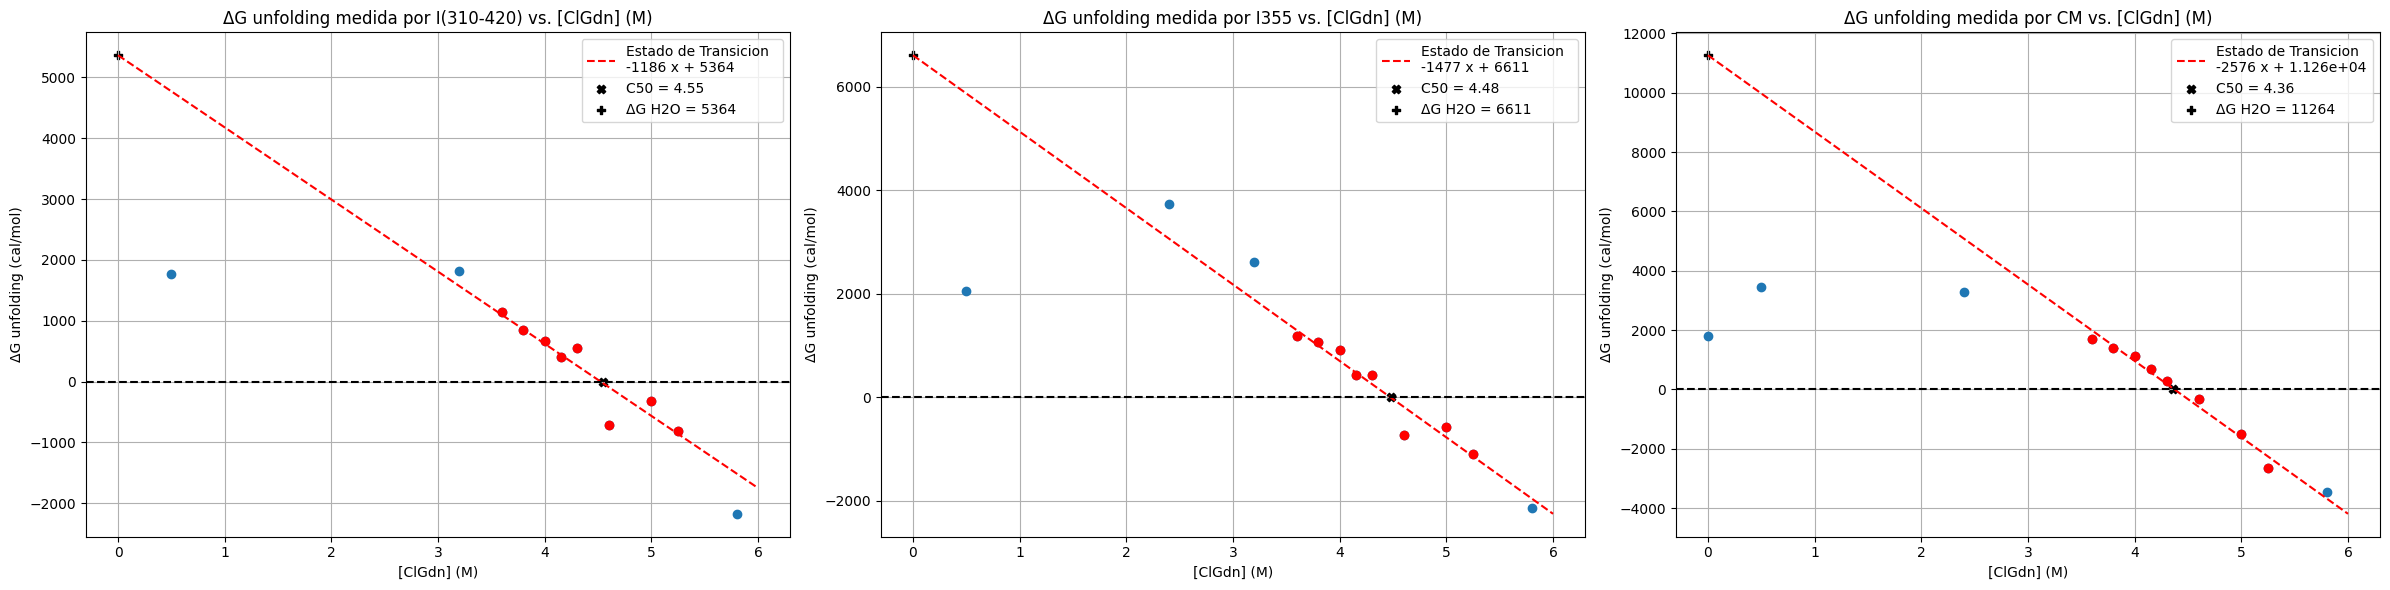

In [65]:
from sklearn.metrics import r2_score
import scipy.optimize as optimize


# Distinguir los puntos
Puntos_IU = 3
Puntos_IN = 5
figura=(24, 6)


# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=figura)


for i, column in enumerate(['I(310-420)', 'I355', 'CM']):
    x_IU = combined_df['ClGdn (M)'].iloc[-Puntos_IU:]
    y_IU = combined_df[column].iloc[-Puntos_IU:]


    x_IN = combined_df['ClGdn (M)'].iloc[1:Puntos_IN]
    y_IN = combined_df[column].iloc[1:Puntos_IN]


    # Regresion lineal de cada conjunto
    z_IU = np.polyfit(x_IU, y_IU, 1)
    p_IU = np.poly1d(z_IU)
    #R2_IU = r2_score(y_IU, p_IU(x_IU))


    z_IN = np.polyfit(x_IN, y_IN, 1)
    p_IN = np.poly1d(z_IN)


    '''SEGUNDO GRAFICO'''
    # Fracciones calculadas de IU e IN
    ITotal_df = pd.DataFrame({
    'IU_'+column: p_IU(combined_df['ClGdn (M)']),
    'IN_'+column: p_IN(combined_df['ClGdn (M)'])
    })


    # Fracciones desplegadas
    ITotal_df['fu_'+column] = (combined_df[column] - ITotal_df['IN_'+column]) / (ITotal_df['IU_'+column] - ITotal_df['IN_'+column])
    #print(ITotal_df)
    
    '''TERCER GRAFICO'''
    # Calculate Ku and Gu
    ITotal_df['Ku_'+column] = ITotal_df['fu_'+column] / (1 - ITotal_df['fu_'+column])
    ITotal_df['Gu_'+column] = -R_cte * T_cte * np.log(ITotal_df['Ku_'+column])


    # Plot data
    axs[i].plot(combined_df['ClGdn (M)'], ITotal_df['Gu_'+column], marker='o', linestyle='')


    # Linear regression
    x_IT, y_IT = combined_df['ClGdn (M)'].iloc[Puntos_IN:len(combined_df['ClGdn (M)'])-Puntos_IU], ITotal_df['Gu_'+column].iloc[Puntos_IN:len(combined_df['ClGdn (M)'])-Puntos_IU]
    axs[i].plot(x_IT, y_IT, marker='o', linestyle='', color='red')


    # Fit line
    p_IT = np.poly1d(np.polyfit(x_IT, y_IT, 1))


    # Plot fit line
    xp_IT = np.linspace(0, 6, 100)
    axs[i].plot(xp_IT, p_IT(xp_IT), linestyle='--', color='red', label='Estado de Transicion {}'.format(p_IT))


    # Find and plot y=0 point
    x_zero = np.abs(p_IT(xp_IT)).argmin()
    axs[i].scatter(xp_IT[x_zero], 0, color='Black', marker='X', label='C50 = {}'.format(round(xp_IT[x_zero], 2)))
    axs[i].scatter(0, p_IT(0), color='Black', marker='P', label='ΔG H2O = {}'.format(round(p_IT(0))))


    # Add horizontal line at y=0
    axs[i].axhline(y=0, color='black', linestyle='--')


    # Add labels and title
    axs[i].set_xlabel('[ClGdn] (M)')
    axs[i].set_ylabel('ΔG unfolding (cal/mol)')
    axs[i].set_title('ΔG unfolding medida por '+column+ ' vs. [ClGdn] (M)')
    axs[i].grid(True)
    axs[i].legend()


# Layout so plots do not overlap
fig.tight_layout()


plt.show()

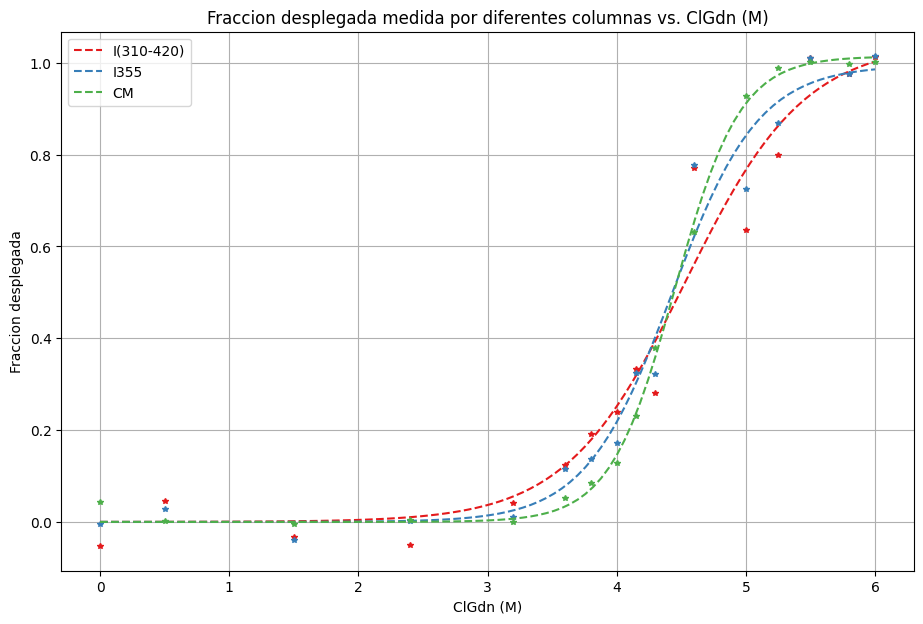

In [59]:
import scipy.optimize as optimize

# Distinguir los puntos
Puntos_IU = 3
Puntos_IN = 5
figura=(11, 7)


# Create a figure
plt.figure(figsize=figura)

# Loop over columns
for i, column in enumerate(['I(310-420)', 'I355', 'CM']):
    # Plot data
    x_IU = combined_df['ClGdn (M)'].iloc[-Puntos_IU:]
    y_IU = combined_df[column].iloc[-Puntos_IU:]

    x_IN = combined_df['ClGdn (M)'].iloc[1:Puntos_IN]
    y_IN = combined_df[column].iloc[1:Puntos_IN]

    # Regresion lineal de cada conjunto
    z_IU = np.polyfit(x_IU, y_IU, 1)
    p_IU = np.poly1d(z_IU)  

    z_IN = np.polyfit(x_IN, y_IN, 1)
    p_IN = np.poly1d(z_IN)

    # Fracciones calculadas de IU e IN
    ITotal_df = pd.DataFrame({
        'IU_'+column: p_IU(combined_df['ClGdn (M)']),
        'IN_'+column: p_IN(combined_df['ClGdn (M)'])
    })

    # Fracciones desplegadas
    ITotal_df['fu_'+column] = (combined_df[column] - ITotal_df['IN_'+column]) / (ITotal_df['IU_'+column] - ITotal_df['IN_'+column])

    # Plot data
    plt.plot(combined_df['ClGdn (M)'], ITotal_df['fu_'+column], marker='*', linestyle='', color=plt.cm.Set1(i), markersize=4)

    # Sigmoid adjustment
    popt, pcov = optimize.curve_fit(lambda x, a, b, c: a / (1 + np.exp(-b * x + c)), combined_df['ClGdn (M)'][1:], ITotal_df['fu_'+column][1:])

    # Plot adjusted curve
    xp = np.linspace(combined_df['ClGdn (M)'].min(), combined_df['ClGdn (M)'].max(), 100)
    plt.plot(xp, popt[0] / (1 + np.exp(-popt[1] * xp + popt[2])), linestyle='--', color=plt.cm.Set1(i), label=column)

plt.xlabel('ClGdn (M)')
plt.ylabel('Fraccion desplegada')
plt.title('Fraccion desplegada medida por diferentes columnas vs. ClGdn (M)')
plt.grid(True)
plt.legend()
plt.show()